# BATDOG

### *The <font color=red>B</font>ayesian <font color=red>A</font>s<font color=red>t</font>rometric <font color=red>D</font>ust Cart<font color=red>og</font>rapher*

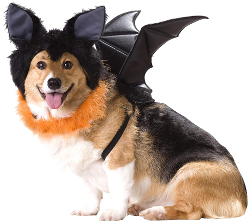

**A Python notebook for processing of parallaxes, comparison with variable star distances and inference of line of sight interstellar extinction to said variable stars.**

------

## Contents

#### 1. Imports/dependencies
#### 2. Loading of data
#### 3. Setup of likelihood & priors
#### 4. Running of emcee
#### 5. Data saving and plotting

------

# 1. Imports and dependencies

Specify directories

In [1]:
# Directory where we can find data for plotting
data_dir = 'data/'

Import packages

In [2]:
# Packages you probably have:
import numpy as np
from scipy.optimize import fmin  # for some data loading shiz
from scipy.stats import norm
import pandas as pd
import sys
import matplotlib.pyplot as plt
#import progressbar  # for timing MCMC running

# Packages you might not have:
import emcee
import corner  # for plots later

# Local .py files that should be in the same dir as this notebook:
# <none>

# 2. Loading of data

## Creation of PLR relation class
We define a PLR relation class with a number of useful methods. Each instance stores its own PLR parameters.

In [3]:
class PLR:
    # Dependencies
    import numpy as np
    
    def __init__(self):
        """Create a, b dictionaries local to each instance for storing 
        PLR parameters.
        """
        self.a = {}
        self.b = {} 
        
    def check_is_list(self, test):
        """Little function for making things lists if they aren't already."""
        if type(test) is not list or np.ndarray:
            return [test]
        else:
            return test
    
    def set_band(self, new_a, new_b, band='default'):
        """Sets the specified band. Defaults to setting it for a single 
        default band. It is entirely possible to pass a list of bands to 
        this method for easy assignment.
        """
        # Typecast inputs as lists if necessary so we can iterate over them
        band = self.check_is_list(band)
        new_a = self.check_is_list(new_a)
        new_b = self.check_is_list(new_b)
               
        # Iterate over input bands and set a, b.
        for a_band, a_new_a, a_new_b in zip(band, new_a, new_b):      
            self.a[a_band] = float(a_new_a)
            self.b[a_band] = float(a_new_b)
    
    def read_band_a(self, band='default'):
        """Reads the specified band a value back to the user."""
        return self.a[band]
    
    def read_band_b(self, band='default'):
        """Reads the specified band b value back to the user."""
        return self.b[band]
    
    def list_of_bands(self):
        """Returns a list of currently loaded bands in a.
        It is assumed that self.a and self.b will always have the same keys,
        at least for proper assignment with the class' set_band method.
        """
        return list(self.a.keys())
        
    # The following are applications of the Leavitt law.
    def magnitude(self, period, band='default'):
        """Returns the apparent magnitude of a variable given a period."""
        return self.a[band] * (np.log10(period) - 1) + self.b[band]
    
    def period(self, magnitude, band='default'):
        """Returns the period of a variable given an apparent magnitude."""
        return np.power(10, (magnitude - self.b[band]) / self.a[band] + 1)

## Setup of a fake distribution
Create a fake data distribution, fuck with it, and go from there.
Try to sample stars from a unifrom density:

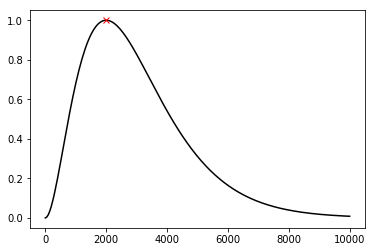

In [4]:
def true_parallax(r):
    """Returns what the exact true parallax should be in arcsecs for a given r."""
    return 1.0/r
    

def stellar_distribution(r, L, fact=1):
    """Returns pdf of a decreasing volume density distribution.
    L = scale length
    fact = in case we need the -ve of the function and as a factor too to normalise it
    """
    return fact/(2*L**3) * r**2 * np.exp(-r/L)


# Set some parameters
N = 100  # number of stars
N_bands = 1  # number of bands
scale = 1000  # scale factor in pc to apply, roughly half the mode of the pdf

# Work out the maximum of our distribution
pdf_max_x = fmin(stellar_distribution, scale*2, args=(scale, -1), disp=False)
pdf_max_y = stellar_distribution(pdf_max_x, scale)

# Normalise the distribution to have its max at 1 for sampling
factor = 1.0 / pdf_max_y 

# Quick test of the distribution
hi = np.linspace(0, scale*10, num=200)
plt.plot(hi, stellar_distribution(hi, scale, fact=factor), 'k-')
plt.plot([pdf_max_x], stellar_distribution(pdf_max_x, scale, fact=factor), 'rx')
plt.show()

Let's sample the real location of the stars

In [5]:
# Some bits of setup of objects
rng = np.random.RandomState(42)  # Use a defined start number for repeatability
sampled_ids = pd.Series(list(range(0, N)))
data = pd.DataFrame(sampled_ids, columns=['ID'])  # Everything we care about will be in here

# Assign a random ra and dec to every star
data['ra'] = pd.Series(np.random.rand(N) * 360)
data['dec'] = pd.Series((np.random.rand(N) - 0.5)*180)

# Sample the pdf to get good values for r
i = 0
r_true = np.zeros(N)
while i < N:
    # Create a test r of size 13 times that of the scale and a deviate test_p to cf with the interval
    test_r = np.random.rand() * scale * 13
    test_p = np.random.rand()
    
    # See if the test point is in the distribution or not
    if test_p < stellar_distribution(test_r, scale, fact=factor):
        r_true[i] = test_r
        i += 1

# Assign the r values we've got to the data frame
data['r_true'] = pd.Series(r_true)
data['omega_true'] = pd.Series((1 / r_true)*1e3)

## Assigning stellar parameters to the distribution
Let's make two PL relations to use; a real one and an experimentally derived one.

In [6]:
real_PLR = PLR()
real_PLR.set_band(-2.7, 3.0)

test_PLR = PLR()
test_PLR.set_band(-2.75, 3.1)

Use the PL relation to infer values for things like magnitude and luminosity.

In [7]:
# Make up some stuff
# data['stellar_r_true'] = pd.Series((2-0.1)*np.random.rand(N) + 0.1)
data['P_true'] = pd.Series((20-5)*np.random.rand(N) + 5)
data['M_true'] = pd.Series(real_PLR.magnitude(data['P_true']))
data['A_true'] = pd.Series((2-0.1)*np.random.rand(N) + 0.1)
data['m_true'] = pd.Series(data['M_true'] + 5*np.log10(data['r_true'] / 10)) + data['A_true']

## Sampling experimental values

Now, let's sample some experimental values. **TODO: define an $r^2e^{-r}$ function to act as a model of the distribution of fractional errors on parameters:**

In [8]:
def error_distribution(value, max_error, min_error):
    """Currently just pulls out a random number *roughly* between max_error and min_error."""
    random_numbers = np.random.rand(value.size) * (max_error - min_error) + min_error
    return value * random_numbers

Next, we want to mess with all of our true values and generate some experimental ones to play with.

In [9]:
# to get deviates, do something like:
# (1 + a_gaussian_deviate(mean=0, s=something)) * true_value
# equivalent to:
# a_gaussian_deviate(mean=1, s=something) * true_value

# Setup some experimental values. 
rng = np.random.RandomState(142)  # Use a defined start number for repeatability

def parallax_error_estimator(magnitude, N):
    """Models parallax error according to Gaia collaboration 
    2018 - Summary of contents & survery properties
    - - - - - - - - - - 
     m   sigma_omega [mas]
    <15  0.02-0.04
     17  0.10
     20  0.70
     21  2.00
    """
    # Always 0.02 below 11
    magnitude = np.where(magnitude <= 11, 0.02, magnitude)
    
    # Make it big for over 21
    magnitude =  np.where(magnitude > 21, 2 * (magnitude-20), magnitude)
    
    # Linear between 0.7 at 20, 2.0 at 21
    magnitude = np.where(magnitude > 20, 1.3 * (magnitude-20) + 0.70, magnitude)
    
    # Linear between 0.1 at 17, 0.7 at 20
    magnitude = np.where(magnitude > 17, 0.20 * (magnitude-17) + 0.10, magnitude)
    
    # Linear between 0.04 at 15, 0.1 at 17
    magnitude = np.where(magnitude > 15, 0.03 * (magnitude-20) + 0.04, magnitude)
    
    # Linear between 0.02 at 11, 0.04 at 15
    magnitude = np.where(magnitude > 11, 0.005 * (magnitude-20) + 0.02, magnitude)
    
    # Add a bit of random error & return
    return magnitude * np.random.normal(loc=1, scale=0.2, size=N)


"""Parallax"""
omega_0 = -0.03  # in mas
parallax_errors = parallax_error_estimator(data['m_true'], N)
data['omega_exp'] = (data['omega_true'] + np.random.normal(loc=0, scale=1, size=N) 
                     * parallax_errors + omega_0)
data['omega_sigma'] = np.abs(parallax_errors)

"""Apparent magnitude (uncorrected for extinction) and extinction estimates"""
# Typical errors from Scowcroft 2016 - typical 0.1-0.2%
app_magnitude_errors = (data['m_true'] 
                        * np.random.normal(loc=0, scale=0.001, size=N))
data['m_exp'] = data['m_true'] + app_magnitude_errors
data['m_sigma'] = np.sqrt(np.abs(app_magnitude_errors)**2 + 0.001**2)
data['A_exp'] = data['A_true'] * (0.9-0.6)*np.random.rand(N)
data['A_sigma'] = np.sqrt(0.05 * data['A_exp'])   # 5% error on all

"""Period"""
# Typical 2.5-5.0% P error
period_errors = data['P_true'] * np.random.normal(loc=0, scale=0.025, size=N)
data['P_exp'] = data['P_true'] + period_errors
data['P_sigma'] = np.sqrt(np.abs(period_errors)**2 + 0.025**2)

"""Inferred absolute magniture from the test PLR"""
### THIS CURRENTLY JUST USES INPUT ERROR - needs knowledge of relationship error also
data['M_exp'] = pd.Series(test_PLR.magnitude(data['P_exp']))
data['M_exp_l'] = pd.Series(test_PLR.magnitude(data['P_exp'] 
                                               + data['P_sigma']))
data['M_exp_u'] = pd.Series(test_PLR.magnitude(data['P_exp'] 
                                               - data['P_sigma']))

"""Inferred radii from the test PLR"""
data['r_exp'] = np.power(10, (data['m_exp'] 
                              - data['M_exp']) / 5 + 1)
data['r_exp_u'] = np.power(10, (data['m_exp'] + data['m_sigma']
                                - data['M_exp_l']) / 5 + 1)
data['r_exp_l'] = np.power(10, (data['m_exp'] - data['m_sigma']
                                - data['M_exp_u']) / 5 + 1)

data[['m_true', 'omega_true', 'omega_exp', 'omega_sigma']]

,m_true,omega_true,omega_exp,omega_sigma
0,14.177907,0.561447,0.545615,0.010648
1,14.771146,0.540604,0.503932,0.003226
2,12.662015,2.247809,2.220121,0.016577
3,17.994694,0.214226,0.469964,0.397779
4,15.999137,0.245910,0.194233,0.061501
5,16.315895,0.274799,0.153715,0.074435
6,16.629559,0.619723,0.561632,0.051674
7,14.114063,0.880095,0.845901,0.007533
8,15.109364,0.404953,0.404678,0.097223
9,15.369985,0.688852,0.692313,0.102432


# 3. Setup of likelihood & priors
**N.B. everything here is returning the result of a log.**

## Priors
#### On $\vec{A_k}$ (the extinction co-efficient in every band for star $k$)
This is simply a uniform prior to constrain the extinction co-efficient to something reasonable.

In [10]:
def prior_extinction(params, r, debug):
    """Currently, a uniform prior between a reasonable range for an 
    extinction co-efficient."""
    # Constants
    max_extinction = 5
    min_extinction = 0
    
    # Set any incorrect range extinctions to -np.inf (log of 0) and return A
    answer = np.where(np.logical_or(params[r['A']] < min_extinction, 
                                    params[r['A']] > max_extinction), 
                      -np.inf, 0)
    
    # Debug - check for infinities
    if debug:
        if np.all(np.isfinite(answer)) == False:
            print("\nprior_extinction encountered infs in:")
            print(np.where(np.isfinite(answer) == False))
    
    return answer

#### Prior on parallax
*Parallax is extremely dangerous. We must deal with it!* The following computes the parallax prior, which is effectively our distance prior but flipped around a bit.

In [11]:
def prior_parallax(params, r, debug):
    """The distance prior but in terms of parallax. We check for any cheeky 
    parallaxes less than zero and set them to -np.inf - if not, set to 
    distance prior.
    """
    # Apply distance prior
    answer = np.where(params[r['omega']] < 0, -np.inf, 
                      np.log(1 / (2 * params[r['L']]**3 * params[r['omega']]**2)) 
                      - 1 / (params[r['omega']] * params[r['L']]))
    
    # Debug - check for infinities
    if debug:
        if np.all(np.isfinite(answer)) == False:
            print("\nprior_parallax encountered infs in:")
            print(np.where(np.isfinite(answer) == False))
    
    return answer

## Likelihood function
Parts of the likelihood fn are defined here.

#### Likelihood of parallax data

In [12]:
def likelihood_parallax(params, r, data, debug):
    """Returns a normal distribution evaluated at the measured Gaia parallax 
    value, with:
    
    mean = the inferred parallax value plus the Gaia zero-point offset
    standard deviation = the error on the Gaia parallax value
    """
    # Pull parallax likelihood from our normal distribution
    answer = np.log(norm(params[r['omega']] + params[r['omega_0']], 
                         data['omega_sigma']).pdf(data['omega_exp']))
    
    # Debug - check for infinities
    if debug:
        if np.all(np.isfinite(answer)) == False:
            print("\nlikelihood_parallax encountered infs in:")
            print(np.where(np.isfinite(answer) == False))
    
    return answer

#### Likelihood of absolute magnitude data

In [13]:
def likelihood_abs_mag(params, r, data, debug):
    """This currently assumes the absolute magnitude is normally distributed.
    IT IS NOT.
    This should be changed later :)
    """
    # Pull likelihood from normal distribution
    answer = np.log(norm(params[r['M']], data['M_exp_u'] 
                    - data['M_exp']).pdf(data['M_exp']))
    
    # Debug - check for infinities
    if debug:
        if np.all(np.isfinite(answer)) == False:
            print("\nlikelihood_abs_mag encountered infs in:")
            print(np.where(np.isfinite(answer) == False))
    
    return answer

#### Likelihood of apparent magnitude data

In [14]:
def likelihood_app_mag(params, r, data, debug):
    """This currently assumes the apparent magnitude is normally distributed.
    IT IS NOT.
    This should be changed later :)
    """
    app_mag_error = np.sqrt(data['m_sigma']**2 + data['A_sigma']**2)
    
    distribution = norm(params[r['M']] + params[r['A']] + 10 
                        - 5 * np.log10(params[r['omega']])
                        , app_mag_error).pdf(np.array(data['m_exp']))
    
    # Only take a log when distribution isn't 
    answer = np.where(distribution > 1e-320, np.log(distribution), -np.inf)
    
    """
    print("data mags: {}".format(np.array(data['m_exp'])))
    print("mags: {}".format(params[r['M']]))
    print("exts: {}".format(params[r['A']]))
    print("log om: {}".format(np.log10(params[r['omega']])))
    print("\ninput: {}".format(params[r['M']] + params[r['A']] + 10 - 5 
                             * np.log10(params[r['omega']])))
    print("dist: {}".format(distribution))
    print("answer: " + str(answer))
    """
    
    # Debug - check for infinities
    if debug:
        if np.all(np.isfinite(answer)) == False:
            print("\nlikelihood_app_mag encountered infs in:")
            print(np.where(np.isfinite(answer) == False))

    return answer

#### Probability of the nuisance magnitude parameters

In [15]:
def likelihood_nuisance(params, r, debug):
    """Currently just a test that both the apparent and absolute magnitudes
    are within reasonable ranges.
    """
    # Constants
    max_M = 0.2
    min_M = 8
    max_m = 7
    min_m = 25
    
    # Test apparent and absolute magnitudes
    test_M = np.logical_or(params[r['M']] < max_M, params[r['M']] > min_M)
    test_m = np.logical_or(params[r['m']] < max_m, params[r['m']] > min_m)
    answer = np.where(np.logical_or(test_M, test_m), -np.inf, 0)
    
    # Debug - check for infinities
    if debug:
        if np.all(np.isfinite(answer)) == False:
            print("\nlikelihood_nuisance encountered infs in:")
            print(np.where(np.isfinite(answer) == False))
    
    return answer

#### Logarithmic combination of all the above

In [16]:
def likelihood_total(params, ranges, data, debug):
    """Sums all of the likelihood functions. Convenience function!"""
    return np.sum(likelihood_parallax(params, ranges, data, debug) 
                  + likelihood_abs_mag(params, ranges, data, debug) 
                  + likelihood_app_mag(params, ranges, data, debug)
                  + likelihood_nuisance(params, ranges, debug))

## Posterior
The last prep step! This function defines our log posterior.

In [17]:
def posterior(params, ranges, data, debug=False):
    """Sums all of the logarithmic likelihoods and priors."""
    
    return np.sum(likelihood_total(params, ranges, data, debug) 
                  + prior_extinction(params, ranges, debug) 
                  + prior_parallax(params, ranges, debug))

# 4. Running of emcee
The game is on! Everything is set up for us to run an mcmc simulation. First, some setup of some plotting help functions:

In [18]:
def plot_chains(sampler, star=0, start=False):
    """Plots the current stored chain output for a given star."""
    names = list(ranges.keys())
    
    # Gets the requisite parameter numbers for a given star
    values = [ranges['omega'][0] + star, ranges['omega_0'], ranges['L'], 
              ranges['A'][0] + star, ranges['m'][0] + star, ranges['M'][0] + star]
    
    # Check if the user specified a start point to plot from
    if start != False:
        s = start
    else:
        s = 0
    
    fig, ax = plt.subplots(7, figsize=(8, 10), sharex=True)

    # Plots likelihood
    ax[0].plot(sampler.lnprobability.T, '-r', alpha=0.2)
    ax[0].set_ylabel('lnprob')

    # Plots parameter evolution
    j=0  # Parameter to try
    for i in values:
        ax[j+1].plot(sampler.chain[:, s:, values[j]].T, '-k', alpha=0.2);
        ax[j+1].set_ylabel(names[j])
        j += 1
    plt.show()
        
def plot_corner(sampler, star=0, start=False):
    """Makes a corner plot using corner.py."""
    names = list(ranges.keys())
    values = [ranges['omega'][0] + star, ranges['omega_0'], ranges['L'], 
              ranges['A'][0] + star, ranges['m'][0] + star, ranges['M'][0] + star]
    
    # Check if the user specified a start point to plot from
    if start != False:
        s = start
    else:
        s = 0
    
    # Make a corner plot
    corner.corner(sampler.flatchain[:, values], 
                  labels=names, 
                  truths=[data['omega_true'][star], 
                          omega_0, 
                          scale, 
                          data['A_true'][star], 
                          data['m_true'][star], 
                          data['M_true'][star]],
                  quantiles=[0.16, 0.5, 0.84],
                  show_titles=True,
                  title_fmt='.4f',
                  title_kwargs={"fontsize":12},
                  scale_hist=True)
    plt.show()

Next, setup our starting guesses:

In [83]:
#------10|-------20|-------30|-------40|-------50|-------60|-------70|------79|xxxxxxxxx

# Define ranges that will be where data is stored in the overall
# mcmc position vector.
ranges = {'omega':list(range(0,N)),
          'omega_0':N,
          'L':N+1,
          'A':list(range(N+2, N+2 + 1*N*N_bands)),
          'm':list(range(N+2 + 1*N*N_bands, N+2 + 2*N*N_bands)),
          'M':list(range(N+2 + 2*N*N_bands, N+2 + 3*N*N_bands))}

# Make starting guesses on all of the parameters.
typical_omega = 1/(scale*2)*1e3 + omega_0
starting_guess = np.where(data['omega_exp']>0.01, data['omega_exp'], typical_omega)
starting_guess = np.append(starting_guess, -0.03)  # omega 0
starting_guess = np.append(starting_guess, 1000.0)  # L
starting_guess = np.append(starting_guess, data['A_exp'])
starting_guess = np.append(starting_guess, data['m_exp'])
starting_guess = np.append(starting_guess, data['M_exp'])

""" TO-DO:
# Define a set of valid guess ranges to use in computing starting
# guesses that aren't going to cause infs.
# These shouldn't be too large so that convergence doesn't
# take too long!
guess_ranges = {'omega': [0.8, 1.2],
                'omega_0': [0.8, 1.2]
                'L': []}
"""

# Check for infinities in likelihood_app_mag. Currently, these seem to have
# been caused by gross extinction underestimates.
counter = 0
while True:
    app_mag_infs = np.asarray(np.where(np.isfinite(
        likelihood_app_mag(starting_guess, ranges, data, debug=False))==False)).flatten()
    
    # Leave the loop if there aren't any infinities
    if app_mag_infs.size == 0:
        print("There are no more infs! Exiting loop now.")
        break
    
    # Update the user on the issues we have
    counter += 1
    print("Oopsie, we hit a snag with extinction. This is attempt {} to fix it.".format(counter))
    print("    there are {} infs.".format(app_mag_infs.size))
    
    # Work out where extinctions & apparent mags are in starting_guess and increment them
    extinction_indices = app_mag_infs + ranges['A'][0]
    app_mag_indices = app_mag_infs + ranges['m'][0]
    starting_guess[extinction_indices] += 0.1
    starting_guess[app_mag_indices] += 0.1

# Some parameters for the MCMC simulation
dimensions = starting_guess.size
walkers = 50 * dimensions

# Extend the starting guess to our number of walkers' dimensions
rng = np.random.RandomState(42)
starting_guesses = starting_guess + 0.0001 * rng.randn(walkers, dimensions)  # SHOULD MULTIPLY BY THE DESIRED RANGE OF PARAMS

/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


Oopsie, we hit a snag with extinction. This is attempt 1 to fix it.
    there are 5 infs.
Oopsie, we hit a snag with extinction. This is attempt 2 to fix it.
    there are 5 infs.
Oopsie, we hit a snag with extinction. This is attempt 3 to fix it.
    there are 4 infs.
Oopsie, we hit a snag with extinction. This is attempt 4 to fix it.
    there are 2 infs.
Oopsie, we hit a snag with extinction. This is attempt 5 to fix it.
    there are 2 infs.
Oopsie, we hit a snag with extinction. This is attempt 6 to fix it.
    there are 2 infs.
Oopsie, we hit a snag with extinction. This is attempt 7 to fix it.
    there are 2 infs.
Oopsie, we hit a snag with extinction. This is attempt 8 to fix it.
    there are 2 infs.
Oopsie, we hit a snag with extinction. This is attempt 9 to fix it.
    there are 2 infs.
Oopsie, we hit a snag with extinction. This is attempt 10 to fix it.
    there are 2 infs.
Oopsie, we hit a snag with extinction. This is attempt 11 to fix it.
    there are 2 infs.
Oopsie, 

Define a function to run emcee for us, providing status updates and **TODO: estimating autocorrelation.**

In [20]:
def run_emcee_for_me(sampler, steps=100, reset=False, guess=0, step_increment=1):
    """Auto-runs emcee, giving an update on each step done and estimating runtime."""    
    # See if we need to start from a guess
    if type(guess) is int:
        # Set to last sampler position
        last_pos = sampler.chain[:, -1, :]
    else:
        # Set to the guess
        last_pos = guess
        
    # Wipe the sampler's memory if required
    if reset == True:
        sampler.reset()
    
    # A bit of start output
    sys.stdout.write("BATDOG is running!\n  steps={}\n\n".format(steps))
    sys.stdout.flush()
    
    # Loop until we reach steps
    current_step = 1
    while current_step <= steps:
        last_pos, last_prob, last_state = sampler.run_mcmc(last_pos, step_increment)
        sys.stdout.write("\rDone {} steps. ETA: {}".format(current_step, "W.I.P."))
        sys.stdout.flush()
        current_step += step_increment
    
    # Add a blank line at the end
    sys.stdout.write("\r                                 ")
    sys.stdout.flush()

Run mcmc

In [62]:
posterior(starting_guess, ranges, data, debug=True)

-1289107.8491232425

In [ ]:
# Define the sampler
sampler = emcee.EnsembleSampler(walkers, dimensions, posterior, 
                                args=(ranges, data), 
                                kwargs={'debug':False}, 
                                threads=8)
sampler.random_state = rng

# time and run the MCMC
#%time pos, prob, state = sampler.run_mcmc(starting_guesses, 1000)

%time run_emcee_for_me(sampler, steps=50, guess=starting_guesses)

BATDOG is running!
  steps=50



/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/_

Done 1 steps. ETA: W.I.P.

In [ ]:
# Plot chains output
plot_chains(sampler, star=10)

In [ ]:
sampler1 = sampler
%time run_emcee_for_me(sampler, reset=True, steps=100)

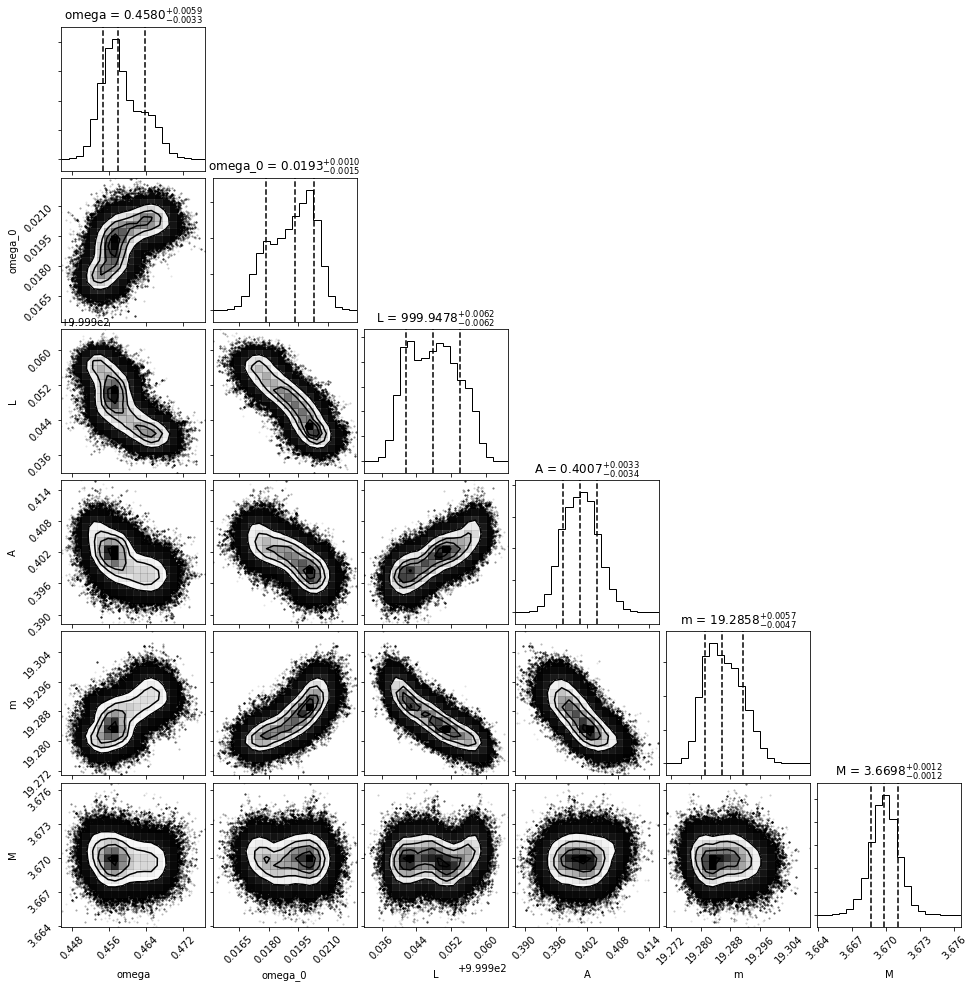

In [79]:
star_to_try = 10

# Make a corner plot
plot_corner(sampler, star=star_to_try)

In [80]:
# Get data on star star_to_try
data.iloc[[star_to_try]][['omega_true', 'omega_exp', 'omega_sigma', 'm_true', 'm_exp', 'm_sigma', 
                          'M_true', 'M_exp', 'M_exp_u', 'M_exp_l', 'A_true', 'A_exp', 'A_sigma']]

,omega_true,omega_exp,omega_sigma,m_true,m_exp,m_sigma,M_true,M_exp,M_exp_u,M_exp_l,A_true,A_exp,A_sigma
10,0.16108,-0.309888,0.434856,18.926903,18.901968,0.024955,3.526984,3.63679,3.641479,3.632118,1.435121,0.132957,0.081534


# 5. Data saving and plotting
First, outline a way to convert back from the emcee format to a format for easy output and comparison.

In [ ]:
(sampler.chain[:, 300:, [0, 1, 2, 3]]).flatchain.shape

In [297]:
list(data.keys())

['ID',
 'ra',
 'dec',
 'r_true',
 'omega_true',
 'P_true',
 'M_true',
 'A_true',
 'm_true',
 'omega_exp',
 'omega_sigma',
 'm_exp',
 'm_sigma',
 'A_exp',
 'A_sigma',
 'P_exp',
 'P_sigma',
 'M_exp',
 'M_exp_l',
 'M_exp_u',
 'r_exp',
 'r_exp_u',
 'r_exp_l']